Parameter Tuning for Image Deconvolution with TV Regularization (ADMM Solver)
=============================================================================

This example demonstrates the use of
[scico.ray.tune](../_autosummary/scico.ray.tune.rst) to tune parameters
for the companion [example script](deconv_tv_admm.rst).

This script is hard-coded to run on CPU only to avoid the large number of
warnings that are emitted when GPU resources are requested but not available,
and due to the difficulty of supressing these warnings in a way that does
not force use of the CPU only. To enable GPU usage, comment out the
`os.environ` statements near the beginning of the script, and change the
value of the "gpu" entry in the `resources` dict from 0 to 1. Note that
two environment variables are set to suppress the warnings because
`JAX_PLATFORMS` was intended to replace `JAX_PLATFORM_NAME` but this change
has yet to be correctly implemented
(see [google/jax#6805](https://github.com/google/jax/issues/6805) and
[google/jax#10272](https://github.com/google/jax/pull/10272)).

In [1]:
# isort: off
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np

import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
import scico.ray as ray
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.ray import tune
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
phantom = SiemensStar(32)
N = 256  # image size
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)

Set up the forward operator and create a test signal consisting of a
blurred signal with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Put main arrays into ray object store.

In [4]:
ray_x_gt, ray_psf, ray_y = ray.put(np.array(x_gt)), ray.put(np.array(psf)), ray.put(np.array(y))

2023-01-26 14:43:35,414	INFO worker.py:1518 -- Started a local Ray instance.


Define performance evaluation function.

In [5]:
def eval_params(config, reporter):
    # Extract solver parameters from config dict.
    λ, ρ = config["lambda"], config["rho"]
    # Get main arrays from ray object store.
    x_gt, psf, y = ray.get([ray_x_gt, ray_psf, ray_y])
    # Put main arrays on jax device.
    x_gt, psf, y = jax.device_put([x_gt, psf, y])
    # Set up problem to be solved.
    A = linop.Convolve(h=psf, input_shape=x_gt.shape)
    f = loss.SquaredL2Loss(y=y, A=A)
    g = λ * functional.L21Norm()
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    # Define solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=A.adj(y),
        maxiter=10,
        subproblem_solver=LinearSubproblemSolver(),
    )
    # Perform 50 iterations, reporting performance to ray.tune every 10 iterations.
    for step in range(5):
        x_admm = solver.solve()
        reporter(psnr=float(metric.psnr(x_gt, x_admm)))

Define parameter search space and resources per trial.

In [6]:
config = {"lambda": tune.loguniform(1e-2, 1e0), "rho": tune.loguniform(1e-1, 1e1)}
resources = {"cpu": 4, "gpu": 0}  # cpus per trial, gpus per trial

Run parameter search.

In [7]:
analysis = tune.run(
    eval_params,
    metric="psnr",
    mode="max",
    num_samples=100,
    config=config,
    resources_per_trial=resources,
    hyperopt=True,
    verbose=True,
)

P:   0 R:   0 T: 100  psnr: 2.23e+01 at lambda: 2.15e-02, rho: 1.08e-01


Display best parameters and corresponding performance.

In [8]:
best_config = analysis.get_best_config(metric="psnr", mode="max")
print(f"Best PSNR: {analysis.get_best_trial().last_result['psnr']:.2f} dB")
print("Best config: " + ", ".join([f"{k}: {v:.2e}" for k, v in best_config.items()]))

Best PSNR: 22.29 dB
Best config: lambda: 2.15e-02, rho: 1.08e-01


Plot parameter values visited during parameter search. Marker sizes are
proportional to number of iterations run at each parameter pair. The best
point in the parameter space is indicated in red.

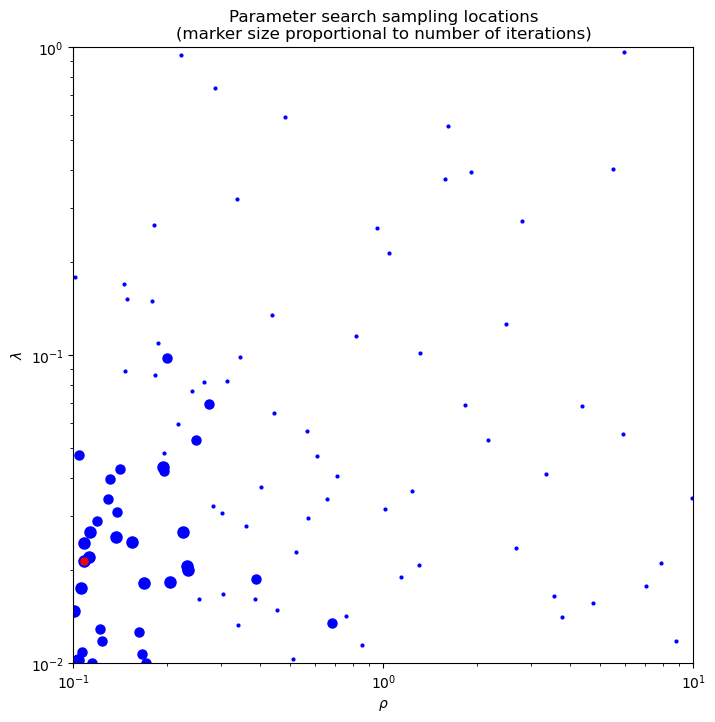

In [9]:
fig = plot.figure(figsize=(8, 8))
for t in analysis.trials:
    n = t.metric_analysis["training_iteration"]["max"]
    plot.plot(
        t.config["lambda"],
        t.config["rho"],
        ptyp="loglog",
        lw=0,
        ms=(0.5 + 1.5 * n),
        marker="o",
        mfc="blue",
        mec="blue",
        fig=fig,
    )
plot.plot(
    best_config["lambda"],
    best_config["rho"],
    ptyp="loglog",
    title="Parameter search sampling locations\n(marker size proportional to number of iterations)",
    xlbl=r"$\rho$",
    ylbl=r"$\lambda$",
    lw=0,
    ms=5.0,
    marker="o",
    mfc="red",
    mec="red",
    fig=fig,
)
ax = fig.axes[0]
ax.set_xlim([config["rho"].lower, config["rho"].upper])
ax.set_ylim([config["lambda"].lower, config["lambda"].upper])
fig.show()

Plot parameter values visited during parameter search and corresponding
reconstruction PSNRs.The best point in the parameter space is indicated
in red.

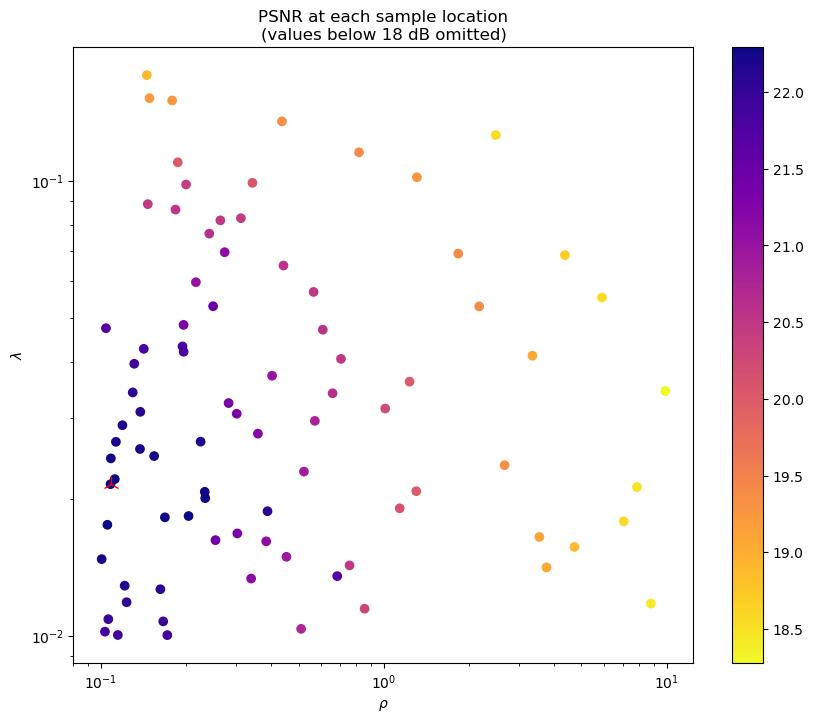

In [10]:
𝜌 = [t.config["rho"] for t in analysis.trials]
𝜆 = [t.config["lambda"] for t in analysis.trials]
psnr = [t.metric_analysis["psnr"]["max"] for t in analysis.trials]
𝜌, 𝜆, psnr = zip(*filter(lambda x: x[2] >= 18.0, zip(𝜌, 𝜆, psnr)))
fig, ax = plot.subplots(figsize=(10, 8))
sc = ax.scatter(𝜌, 𝜆, c=psnr, cmap=plot.cm.plasma_r)
fig.colorbar(sc)
plot.plot(
    best_config["lambda"],
    best_config["rho"],
    ptyp="loglog",
    lw=0,
    ms=12.0,
    marker="2",
    mfc="red",
    mec="red",
    fig=fig,
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\lambda$")
ax.set_title("PSNR at each sample location\n(values below 18 dB omitted)")
fig.show()